<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;"><img src="https://pbs.twimg.com/profile_images/1187259618/unidata_logo_rgb_sm_400x400.png" alt="Unidata Logo" style="height: 98px;"></div>

<h1>Upper Air and the Skew-T Log-P</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="https://unidata.github.io/MetPy/_images/sphx_glr_Advanced_Sounding_001.png" alt="Example Skew-T" style="height: 500px;"></div>


## Overview:

* **Teaching:** 30 minutes
* **Exercises:** 60 minutes

### Questions
1. Where can upper air data be found and what format is it in?
2. How can upper air data be obtained using MetPy?
3. How can MetPy be used to make a Skew-T Log-P diagram?
4. What thermodynamic calculations can be performed on the data?

### Objectives
1. Load upper air data from remote data servers
2. Make a simple Skew-T
3. Perform thermodynamic calculations
3. Make an advanced Skew-T
4. Add a hodograph

## 1. Load upper air data

Upper air observations are reported as a plain text file in a tabular format that represents the down sampled raw data transmitted by the balloon. Data are reported an mandatory levels and at levels of significant change. An example of the beginning of sounding data may look like this:

```
-----------------------------------------------------------------------------
   PRES   HGHT   TEMP   DWPT   RELH   MIXR   DRCT   SKNT   THTA   THTE   THTV
    hPa     m      C      C      %    g/kg    deg   knot     K      K      K 
-----------------------------------------------------------------------------
 1000.0    270                                                               
  991.0    345   -0.3   -2.8     83   3.15      0      0  273.6  282.3  274.1
  984.0    403   10.2   -7.8     27   2.17    327      4  284.7  291.1  285.0
  963.0    581   11.8   -9.2     22   1.99    226     17  288.0  294.1  288.4
  959.7    610   11.6   -9.4     22   1.96    210     19  288.1  294.1  288.5
  ```
  
The data are available to download from the [University of Wyoming archive](http://weather.uwyo.edu/upperair/sounding.html) and the [Iowa State archive](https://mesonet.agron.iastate.edu/archive/raob/). MetPy has the capability to create a request to these sites and obtain the data in a sensible format for plotting and analysis. Let's download some data from May 10, 2010 - a severe weather day in central Oklahoma.

First, we need to create a `datetime` object that has the time of observation we are looking for. and then pass it as the first argument into MetPy's `get_upper_air_data` function. We also include the station identifier (OUN for Norman, OK). By default, the data will be obtained from the University of Wyoming server.

In [1]:
from datetime import datetime
from metpy.io.upperair import get_upper_air_data

ds = get_upper_air_data(datetime(2010, 5, 10, 21), 'OUN')

We can peek at the variables in the dataset object `ds` using a netCDF-like interface:

In [2]:
print(list(ds.variables))

['pressure', 'temperature', 'dewpoint', 'u_wind', 'v_wind', 'speed', 'direction']


Notice the MetPy has already broken down the winds into the u and v components as those are needed for many plotting and analysis operations. Next, we can pull out the data we want to use for our plotting and analysis purposes.

In [3]:
p = ds.variables['pressure'][:]
T = ds.variables['temperature'][:]
Td = ds.variables['dewpoint'][:]
u = ds.variables['u_wind'][:]
v = ds.variables['v_wind'][:]

### Exercise: Find your own data

<hr style="height:2px;">

## 2. Make a Simple Skew-T

Knowing what we already know about plotting in Python, we can explore the data a little, but the plots are not exactly what we are used to looking at.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

(1000, 0)

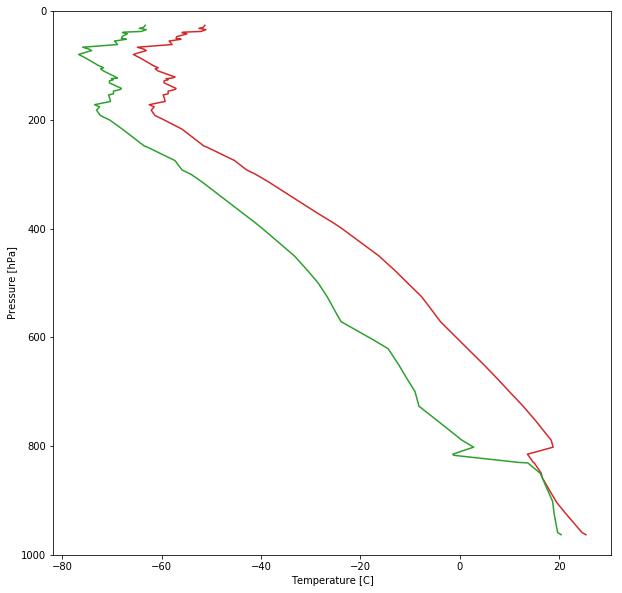

In [5]:
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot()

ax1.set_xlabel(r'Temperature [C]')
ax1.set_ylabel(r'Pressure [hPa]')

ax1.plot(T, p, color='tab:red')
ax1.plot(Td, p, color='tab:green')

ax1.set_ylim(1000, 0)

As meteorologists, we are used to looking at soundings on the Skew-T Log-p diagram. This is a tricky plot to make – the isotherms are skewed diagonally, pressure is plotted in log space, and we often want to see fiducial lines showing dry adiabats, moist adiabats, etc. MetPy has the capability to make a Skew-T baked in!

(-40, 60)

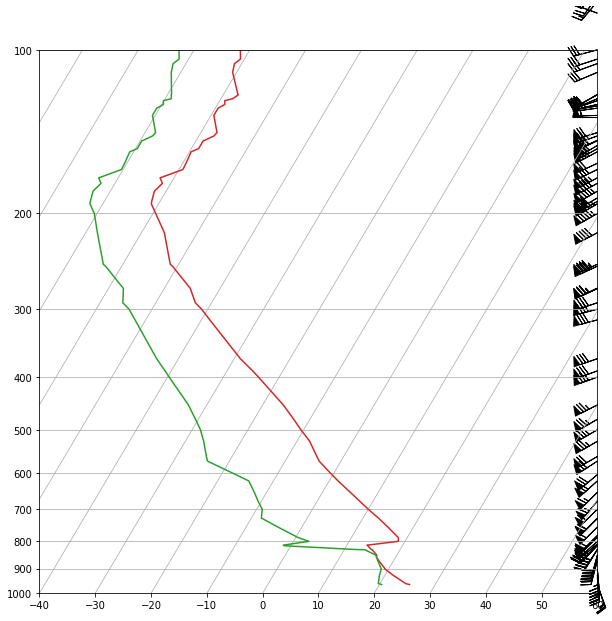

In [6]:
from metpy.plots import SkewT

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(10, 10))
skew = SkewT(fig)

# Plot the data using normal plotting functions, all of the transforms
# happen in the background!
skew.plot(p, T, color='tab:red')
skew.plot(p, Td, color='tab:green')

# Add wind barbs
skew.plot_barbs(p, u, v)

# Set some sensible axis limits
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

### Exercise: Plot your data

<hr style="height:2px;">

## 3. Perform thermodynamic calculations

Generally we are interested in some thermodynamic parameters when looking at upper air data. We often want to know what the level of free convection (LFC) or the lifted condensation level (LCL) is for a given sounding. While it can be done graphically, there are no analytic solutions to these equations. MetPy implements these calculations for you, taking care of the numerical methods and testing. Let’s calculate some of these values and add them to our Skew-T.

In [7]:
import metpy.calc as mpcalc

lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td)

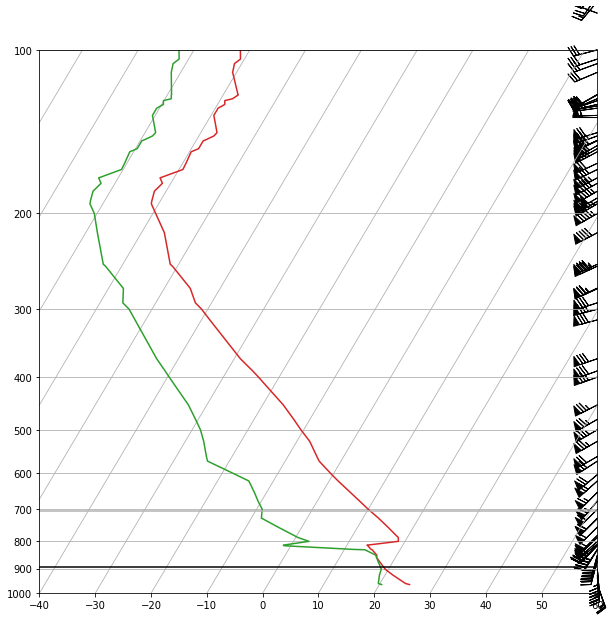

In [8]:
skew.ax.axhline(lcl_pressure, color='black')
skew.ax.axhline(lfc_pressure, color='0.7')
fig

When considering the stability of the atmosphere we often talk about the ideal parcel path. A parcel lifted from the surface along a dry adiabatic path until it becomes saturated, then lifted along a moist adiabatic path. MetPy will calculated the ideal parcel path given the starting point (generally the surface).

In [9]:
parcel_path = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

In [10]:
print(parcel_path)

[  25.4          25.04526852   22.84915308   21.9865289    19.90865028   19.87154055   18.26275698   17.73048578   17.3979245    16.5921648   16.54911741   15.98348372   15.89545431   15.7096988    15.31650626   14.72548316   14.41599095   13.10894133   11.77920232   11.72304926   10.30838133    9.01067716    7.5849641     5.70545574    4.64725993    2.34597565    1.54234187   -1.14482386   -3.23945233   -5.1909697   -7.95147588  -13.56190558  -14.87051904  -17.49390536  -26.37340628  -28.95046696  -30.51207151  -34.03350599  -34.16304266  -39.7530249  -40.24012066  -48.39105455  -53.37058277  -55.84846531  -56.48196997  -57.34630304  -59.0739381   -61.08068302  -62.4495491   -64.55114346  -66.09422093  -68.93827859  -69.69467155  -70.45861611  -71.61901106  -71.73602269  -72.79724293  -73.59291331  -77.19555707  -77.70025552  -79.40716521  -79.92680757  -80.27522554  -81.1533542   -81.5962764  -82.4900077   -82.57996749  -87.60610667  -89.55785246  -90.55361651  -92.58711109 -100.4294

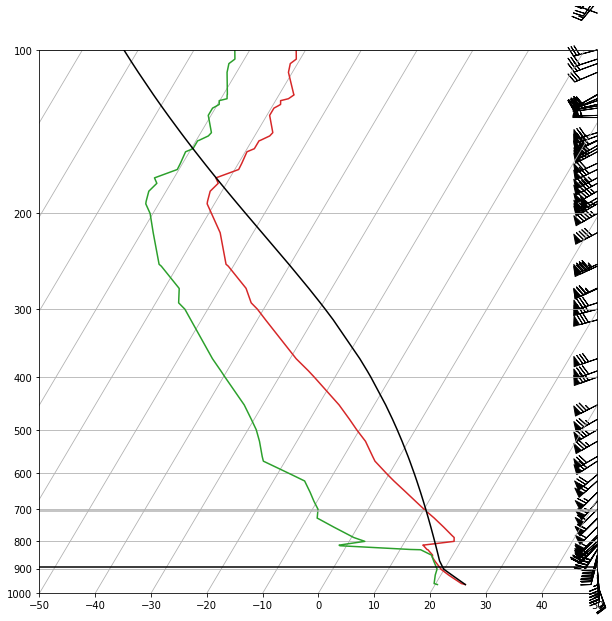

In [11]:
skew.plot(p, parcel_path, color='black')
fig

### Exercise: Do these calculations on your data

<hr style="height:2px;">

## 4. Make an Advanced Skew-T

Now that you’ve got the basics of the Skew-T down, it’s time to really dress it up. You could use the `moist_lapse` and `dry_lapse` functions in the calculations module to calculate and dry fiducials on the plot, but MetPy can do it for us.

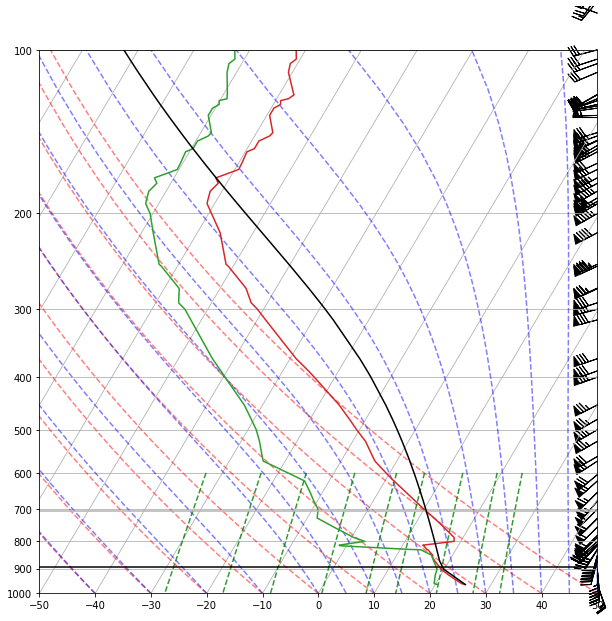

In [12]:
# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

fig

We can also shade the areas that represent CAPE and CIN to make things a little more visually appealing.

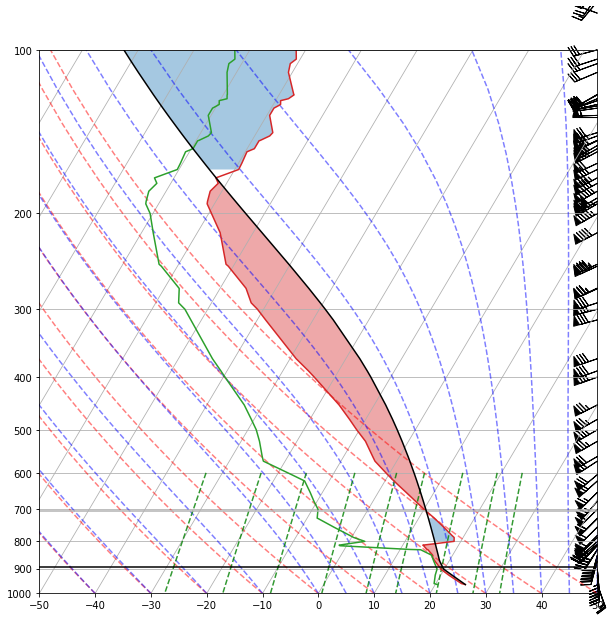

In [13]:
# Shade areas representing CAPE and CIN
skew.shade_cin(p, T, parcel_path)
skew.shade_cape(p, T, parcel_path)
fig

We can also highlight certain isotherms. One important isotherm is the freezing point of water. Let’s add a highlight to that line. The skew transform happens automatically!

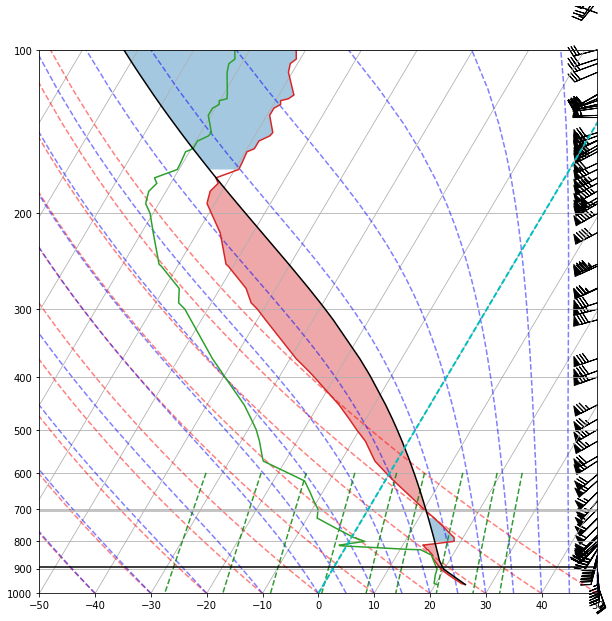

In [14]:
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
fig

## 5. Add a Hodograph

We can also add a hodograph to the plot, using matplotlib's `inset_axes` function:

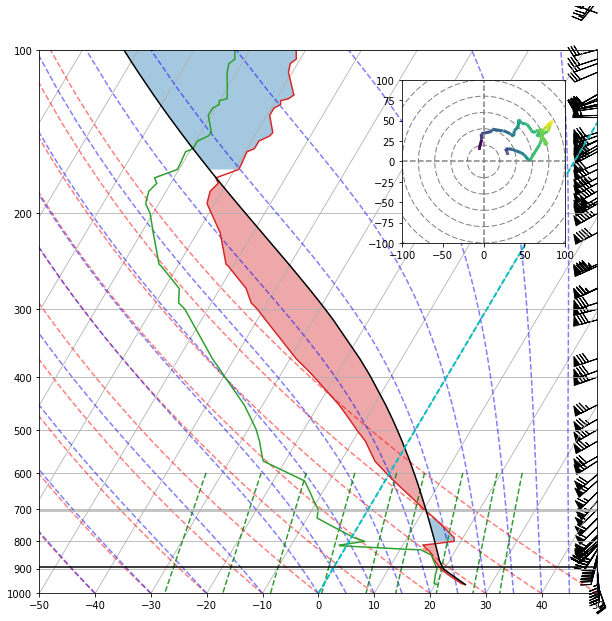

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from metpy.plots import Hodograph
from metpy.units import units
import numpy as np
# Get the wind speed from the dataset
windspeed = ds.variables['speed'][:]

# Add an axes to the plot
ax_hod = inset_axes(skew.ax, '30%', '30%', loc=1, borderpad=3)

# Plot the hodograph
h = Hodograph(ax_hod, component_range=100.)

# Grid the hodograph
h.add_grid(increment=20)

# Plot the data on the hodograph
mask = (p >= 100 * units.mbar)
h.plot_colormapped(u[mask], v[mask], windspeed[mask])  # Plot a line colored by wind speed

fig

### Exercise: Dress up your Skew-T

<hr style="height:2px;">

## Putting it all together
By combining the steps above into a single code block we can see that it really doesn't take much at all to make a very complex figure!

(-40, 60)

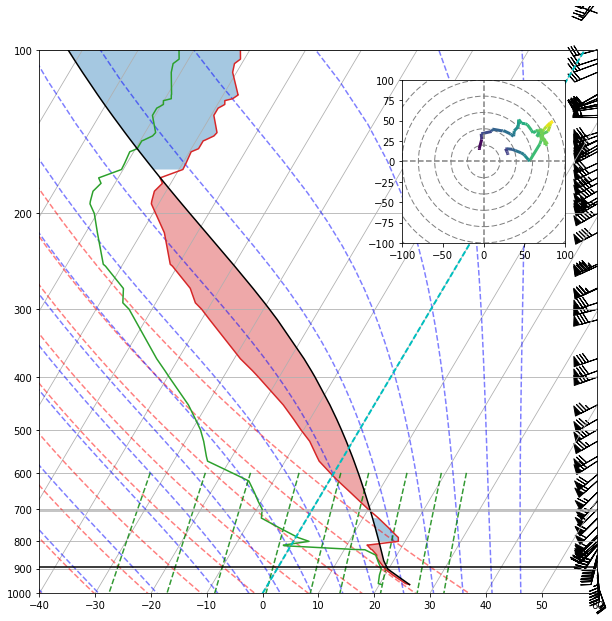

In [16]:
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np

from datetime import datetime
from metpy.io.upperair import get_upper_air_data
from metpy.plots import Hodograph, SkewT
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


ds = get_upper_air_data(datetime(2010, 5, 10, 21), 'OUN')

p = ds.variables['pressure'][:]
T = ds.variables['temperature'][:]
Td = ds.variables['dewpoint'][:]
u = ds.variables['u_wind'][:]
v = ds.variables['v_wind'][:]
windspeed = ds.variables['speed'][:]

lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td)
parcel_path = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(10, 10))
skew = SkewT(fig)

# Plot the data
skew.plot(p, T, color='tab:red')
skew.plot(p, Td, color='tab:green')

# Plot thermodynamic parameters and parcel path
skew.plot(p, parcel_path, color='black')
skew.ax.axhline(lcl_pressure, color='black')
skew.ax.axhline(lfc_pressure, color='0.7')

# Add the relevant special lines
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Shade areas representing CAPE and CIN
skew.shade_cin(p, T, parcel_path)
skew.shade_cape(p, T, parcel_path)

# Add wind barbs
skew.plot_barbs(p, u, v)

# Add an axes to the plot
ax_hod = inset_axes(skew.ax, '30%', '30%', loc=1, borderpad=3)

# Plot the hodograph
h = Hodograph(ax_hod, component_range=100.)

# Grid the hodograph
h.add_grid(increment=20)

# Plot the data on the hodograph
mask = (p >= 100 * units.mbar)
h.plot_colormapped(u[mask], v[mask], windspeed[mask])  # Plot a line colored by wind speed

# Set some sensible axis limits
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)